In [1]:
# import standard libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import ast 
import json

In [2]:
task_summary = pd.read_csv('../Data/task_summary.csv')

In [3]:
task_summary.head()

,task_label,num_train,train_input_widths,train_input_heights,train_output_widths,train_output_heights,test_input_width,test_input_height,test_output_width,test_output_height,unique_colors
0,007bbfb7.json,5,"[3, 3, 3, 3, 3]","[3, 3, 3, 3, 3]","[9, 9, 9, 9, 9]","[9, 9, 9, 9, 9]",[3],[3],[9],[9],"[0, 2, 4, 6, 7]"
1,00d62c1b.json,5,"[6, 10, 10, 10, 20]","[6, 10, 10, 10, 20]","[6, 10, 10, 10, 20]","[6, 10, 10, 10, 20]",[20],[20],[20],[20],"[0, 3, 4]"
2,017c7c7b.json,3,"[3, 3, 3]","[6, 6, 6]","[3, 3, 3]","[9, 9, 9]",[3],[6],[3],[9],"[0, 1, 2]"
3,025d127b.json,2,"[9, 9]","[14, 8]","[9, 9]","[14, 8]",[10],[10],[10],[10],"[0, 2, 4, 6, 8]"
4,045e512c.json,3,"[21, 21, 21]","[21, 21, 21]","[21, 21, 21]","[21, 21, 21]",[21],[21],[21],[21],"[0, 1, 2, 3, 4, 5, 6, 8]"


In [4]:
exclude_cols = ['task_label', 'num_train']
list_cols = [col for col in task_summary.columns if col not in exclude_cols]

# convert objects within columns containing lists from strings to lists
for col in list_cols:
    task_summary[col] = task_summary[col].apply(ast.literal_eval)

In order to verify the relationship between the occurence of unique colors and the size of training examples per task, we will first create boolean columns representing whether a color was present in the training task. After these columns are created, we will create a correlation plot between the size of the training task and the unique colors. 

In [5]:
def dummy_encode(df, cols):
    for col in cols:
        df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix='train_size')], axis=1)
    
    return df

def get_list_dummies(series): 
    return pd.get_dummies(series.apply(pd.Series).stack()).sum(level=0)

def create_corr_plot(df, title):
    corr = df.corr()

    fig, ax = plt.subplots(figsize=(16, 16))

    top_corr = sns.heatmap(corr, 
                           xticklabels=corr.columns,
                           yticklabels=corr.columns, 
                           vmin=-1, vmax=1, center=0,
                           cmap = "coolwarm",
                           ax = ax)

    ax.set_title(title, size = 20, pad = 10.0)

    # Adjust top and bottom of graph due to being cut off
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t); # update the ylim(bottom, top) values

In [6]:
num_train = dummy_encode(task_summary.num_train.to_frame(), ['num_train'])

In [7]:
unique_colors = get_list_dummies(task_summary.unique_colors)
input_widths = get_list_dummies(task_summary.train_input_heights)


num_train_and_colors = pd.concat([num_train, unique_colors], axis=1)

In [8]:
num_train_and_colors.head()

,train_size_2,train_size_3,train_size_4,train_size_5,train_size_6,train_size_7,train_size_8,train_size_10,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,1,0,0
1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0
2,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0
4,0,1,0,0,0,0,0,0,1,1,1,1,1,1,1,0,1,0


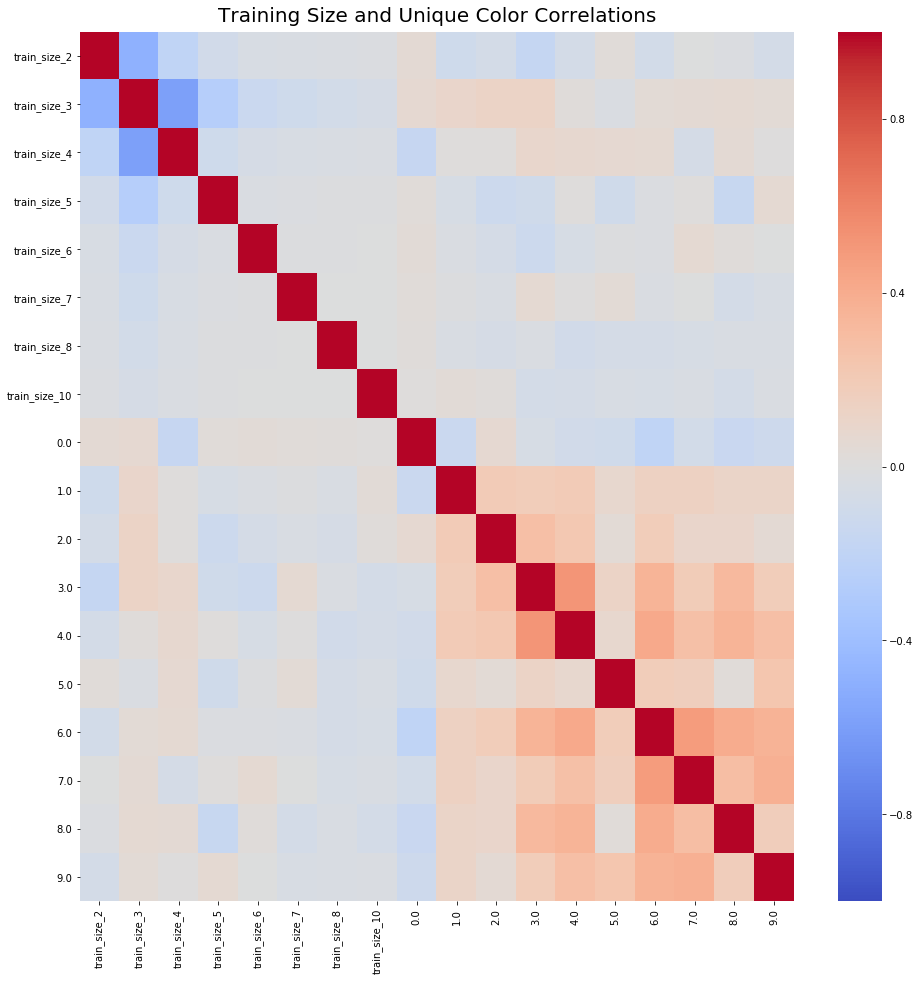

In [9]:
create_corr_plot(num_train_and_colors, "Training Size and Unique Color Correlations")

## Input Dimensions 

Next we will use a correlation plot to determine whether there is a relationship between the average dimensions of the training sets and the number of tasks in the training set. 

In [10]:
# calculate average of input dimensions 
input_dims_avg = task_summary[['train_input_widths', 'train_input_heights', 
                               'train_output_widths', 'train_output_heights']]

input_dims_avg = input_dims_avg.applymap(np.mean)

num_train_and_dimensions = pd.concat([task_summary.num_train, input_dims_avg], axis=1)

num_train_and_dimensions.head()

,num_train,train_input_widths,train_input_heights,train_output_widths,train_output_heights
0,5,3.0,3.0,9.0,9.0
1,5,11.2,11.2,11.2,11.2
2,3,3.0,6.0,3.0,9.0
3,2,9.0,11.0,9.0,11.0
4,3,21.0,21.0,21.0,21.0


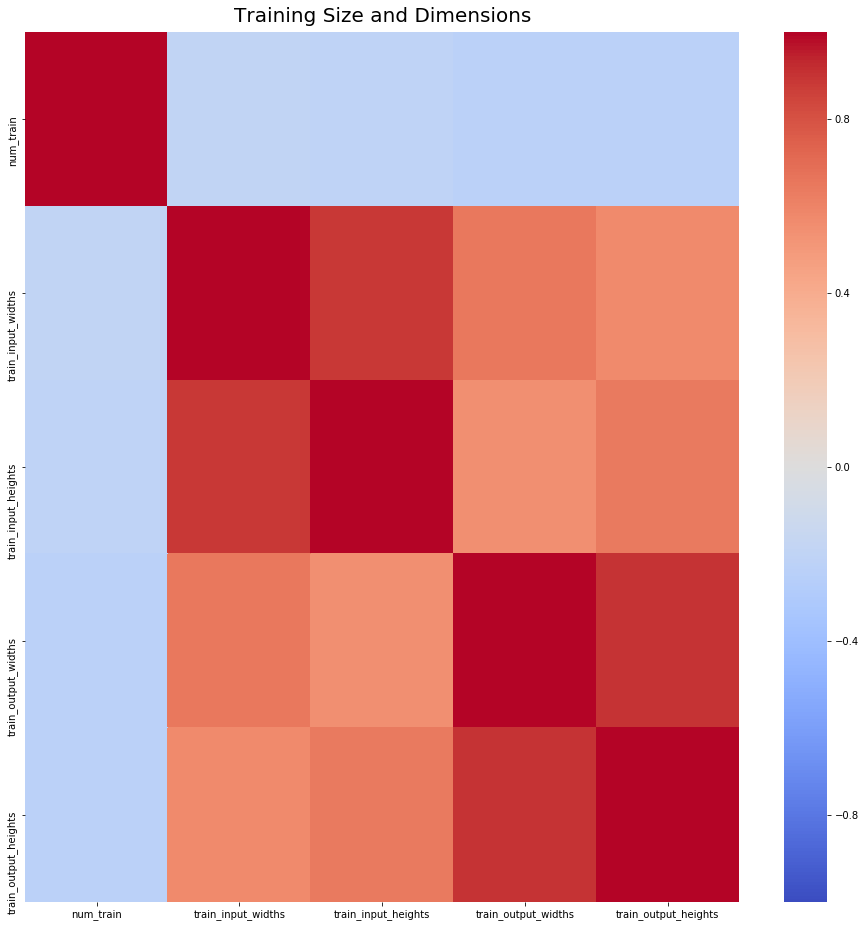

In [11]:
create_corr_plot(num_train_and_dimensions, "Training Size and Dimensions")

## Bootstrapping

According to the correlation plot, there is no significant correlation between the size of each training set and the dimensions of the inputs and outputs. In order to verify this, we will use bootstrapping to calculate the means of the dimensions of the inputs, grouped by the size of their training example. 

We are essentially checking if, for example, the average input dimensions increases as the number of training tasks increasese. 
In other words, our null hypothesis is as follows: 

There is no significant difference between the input dimensions of training tasks (grouped by the number of inputs and outputs in the training set). 

Our alternative hypothesis is as follows: 
There is a significant difference between the input dimensions of training tasks (grouped by the number of inputs and outputs in the training set). 

In [12]:
# define function to perform bootstrapping
def perform_bootstrap_analysis(col, n_1, n_2, N=10000): 

    group1 = num_train_and_dimensions[col][num_train_and_dimensions.num_train == n_1]
    group2 = num_train_and_dimensions[col][num_train_and_dimensions.num_train == n_2]

    feature = pd.concat([group1, group2])
    
    bs_mean_diff = np.empty(N)
    
    mean_total     = np.mean(feature)
    group1_shifted = group1 - np.mean(group1) + mean_total
    group2_shifted = group2 - np.mean(group2) + mean_total 
    
    for i in range(N): 
        bs_group1 = np.random.choice(group1_shifted, size=len(feature))
        bs_group2 = np.random.choice(group2_shifted, size=len(feature))
        bs_mean_diff[i] = np.mean(bs_group1) - np.mean(bs_group2)
        
    emperical_mean_diff = np.mean(group1) - np.mean(group2)
    p = np.sum(bs_mean_diff >= emperical_mean_diff) / len(bs_mean_diff)
    
    plt.figure(figsize=(12,6))
    _ = plt.hist(bs_mean_diff, bins=30)
    _ = plt.xlabel('Mean Differences')
    _ = plt.ylabel('Number of Occurences')
    _ = plt.title('Distribution of Difference Between Means of\n' + 
              f'group: Training Size = {n_1}' + f' and group: Training Size = {n_2}')

    percentiles = np.percentile(bs_mean_diff, q=[2.5, 25, 50, 75, 97.5])
    _ = plt.axvline(percentiles[0], color='r', linestyle='--') # 25th percentile
    _ = plt.axvline(percentiles[2], color='r', linestyle='-.') # 50th percentile
    _ = plt.axvline(percentiles[4], color='r', linestyle='-.') # 75th percentile
    
    print(f"p-value: {p}")
    print(f"Observed mean difference: {emperical_mean_diff: 6.4f}")

We will now perform the bootstrapping on the largest groups (training sets with sizes of 2, 3, and 4 as observed from the storytelling section). 

### Input Widths

p-value: 0.8717
Observed mean difference: -0.4953


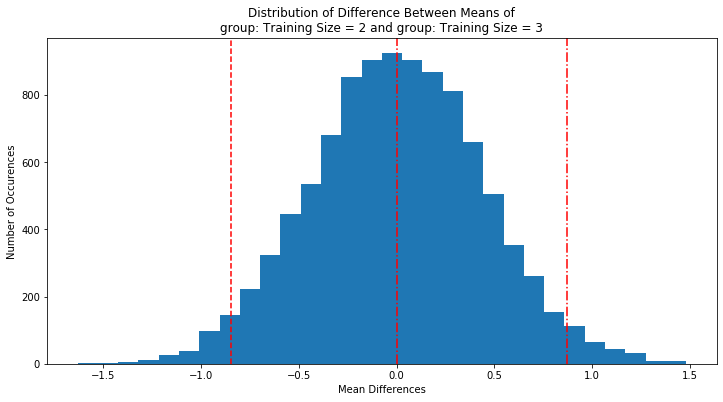

In [13]:
col = 'train_input_widths'
perform_bootstrap_analysis(col, 2, 3)

p-value: 0.0413
Observed mean difference:  1.1606


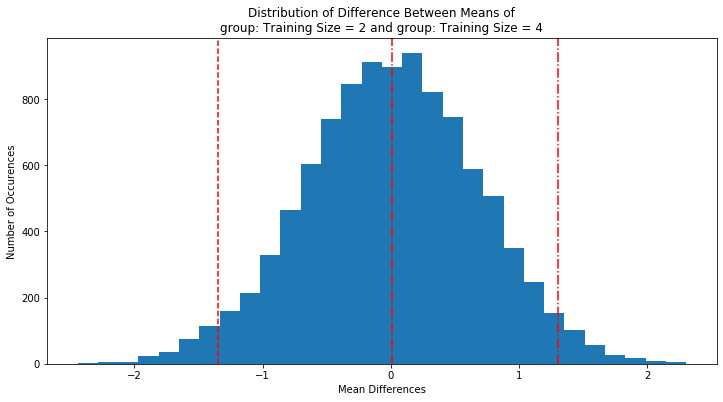

In [14]:
perform_bootstrap_analysis(col, 2, 4)

p-value: 0.0001
Observed mean difference:  1.6559


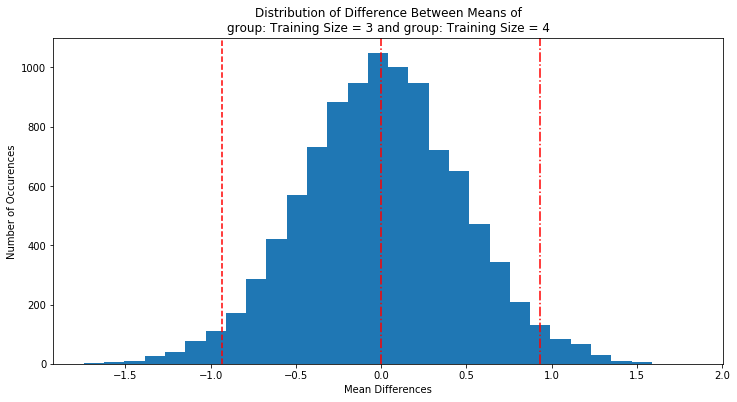

In [15]:
perform_bootstrap_analysis(col, 3, 4)

### Input Heights

p-value: 0.9741
Observed mean difference: -0.8489


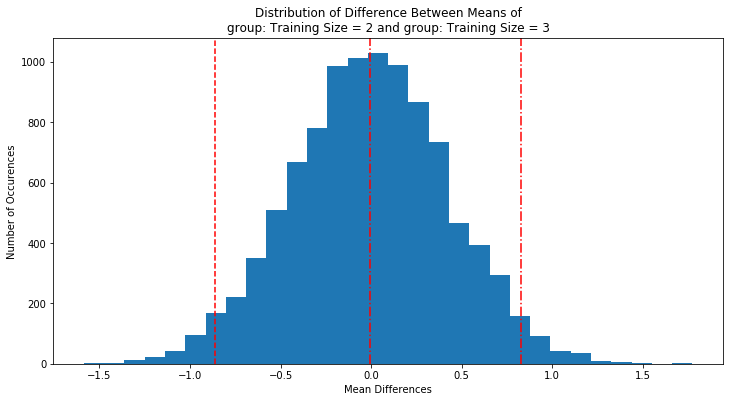

In [16]:
col = 'train_input_heights'
perform_bootstrap_analysis(col, 2, 3)

p-value: 0.0529
Observed mean difference:  1.0353


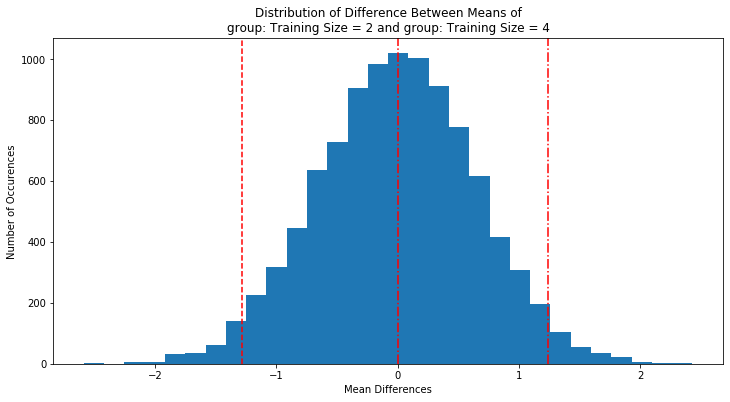

In [17]:
perform_bootstrap_analysis(col, 2, 4)

p-value: 0.0
Observed mean difference:  1.8841


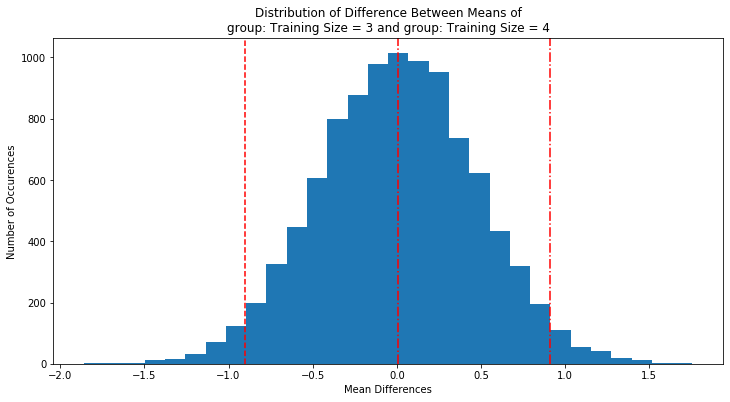

In [18]:
perform_bootstrap_analysis(col, 3, 4)

### Output Widths 

p-value: 0.078
Observed mean difference:  0.5856


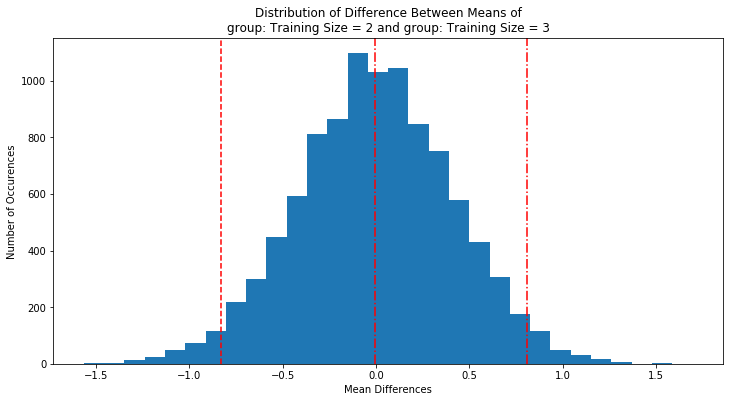

In [19]:
col = 'train_output_widths'
perform_bootstrap_analysis(col, 2, 3)

p-value: 0.0016
Observed mean difference:  1.8789


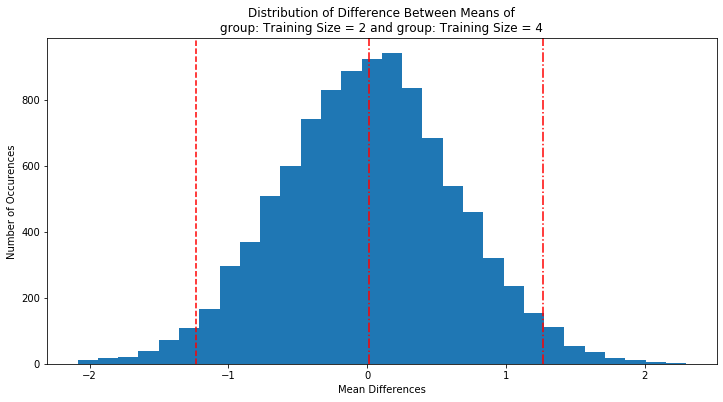

In [20]:
perform_bootstrap_analysis(col, 2, 4)

p-value: 0.0027
Observed mean difference:  1.2932


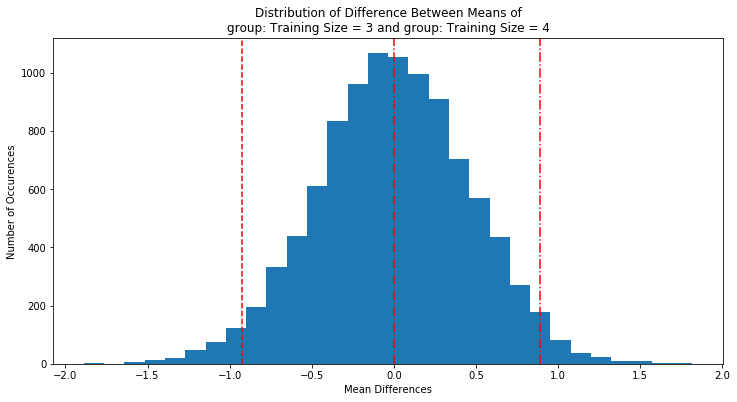

In [21]:
perform_bootstrap_analysis(col, 3, 4)

### Output Heights

p-value: 0.2092
Observed mean difference:  0.3171


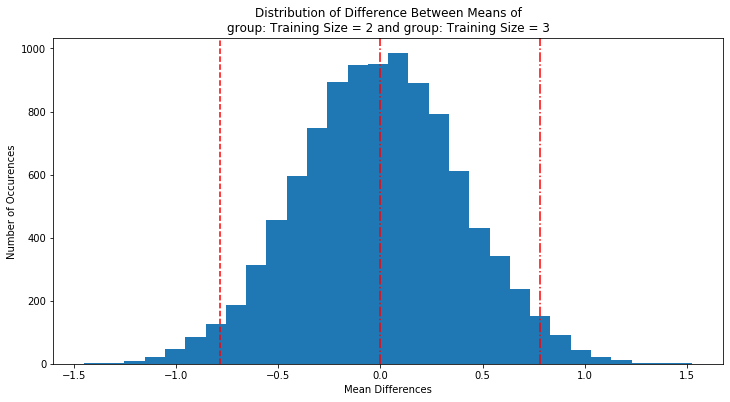

In [22]:
col = 'train_output_heights'
perform_bootstrap_analysis(col, 2, 3)

p-value: 0.0002
Observed mean difference:  1.9909


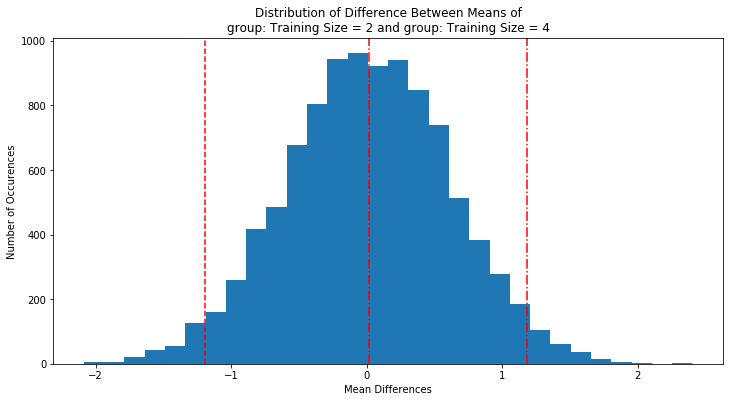

In [23]:
perform_bootstrap_analysis(col, 2, 4)

p-value: 0.0003
Observed mean difference:  1.6738


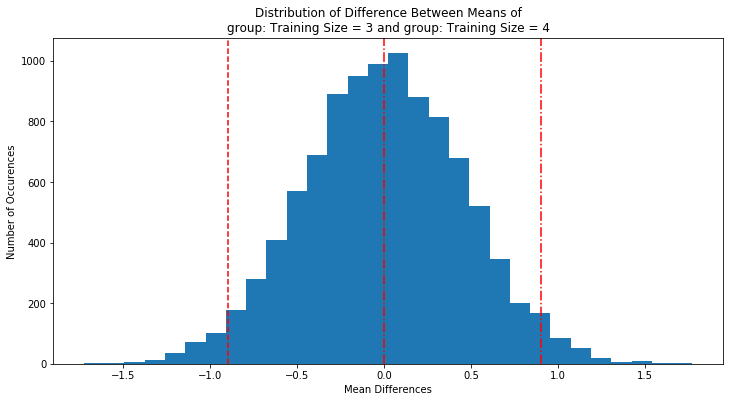

In [24]:
perform_bootstrap_analysis(col, 3, 4)